# Tarea 4: EDA Multi-fuentes y Joins - Fill in the Blanks¶

##  Objetivos Básicos
* Aprender a integrar datos de múltiples fuentes

* Dominar los diferentes tipos de joins con pandas
* Realizar análisis agregados con groupby
* Crear reportes consolidados de datos integrados

### Paso 1: Setup Inicial: CONTEXTO DE NEGOCIO (CRISP-DM: Business Understanding)

In [1]:
# Importar librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path

# Configurar visualizaciones
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Setup completo para análisis multi-fuentes!")

✅ Setup completo para análisis multi-fuentes!


## Paso 2 Carga de Datos desde Múltiples Fuentes


In [2]:
# === CARGAR DATOS DE MÚLTIPLES FUENTES ===

# 1. Cargar datos de viajes desde Parquet (Dataset oficial completo NYC)
print("Cargando datos oficiales de NYC Taxi (dataset completo)...")
trips_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"

# Cargar dataset oficial (~3M registros de enero 2023)
trips = pd.read_parquet(trips_url)  # función para leer archivos .parquet (más eficiente que CSV) --read_parquet

print(f"   Viajes cargados: {trips.shape[0]:,} filas, {trips.shape[1]} columnas")
print(f"   Columnas: {list(trips.columns)}")
print(f"   Período: {trips['tpep_pickup_datetime'].min()} a {trips['tpep_pickup_datetime'].max()}")
print(f"   Tamaño en memoria: {trips.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# 2. Cargar datos de zonas desde CSV (Dataset oficial completo)
print("\nCargando datos oficiales de zonas NYC...")
zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zones = pd.read_csv(zones_url)  # función estándar para archivos CSV --read_csv

print(f"   Zonas cargadas: {zones.shape[0]} filas, {zones.shape[1]} columnas")
print(f"   Columnas: {list(zones.columns)}")
print(f"   Boroughs únicos: {zones['Borough'].unique()}")

# 3. Cargar calendario de eventos desde JSON
print("\nCargando datos de calendario de eventos...")
calendar_url = "https://juanfkurucz.com/ucu-id/ut1/data/calendar.json"
calendar = pd.read_json(calendar_url)  # función para archivos JSON --read_json
calendar['date'] = pd.to_datetime(calendar['date']).dt.date  # convertir strings a fechas, luego extraer solo la fecha

print(f"   Eventos calendario: {calendar.shape[0]} filas")
print(f"   Columnas: {list(calendar.columns)}")

# 4. Mostrar primeras filas de cada dataset
print("\nVISTA PREVIA DE DATOS:")
print("\n--- TRIPS ---")
print(trips.head())  # método para mostrar primeras filas de un DataFrame --HEAD
print("\n--- ZONES ---")
print(zones.describe())  # mismo método para ver estructura de datos -- DESCRIBE
print("\n--- CALENDAR ---")
print(calendar.info())  # revisar formato de los eventos -- INFO

Cargando datos oficiales de NYC Taxi (dataset completo)...
   Viajes cargados: 3,066,766 filas, 19 columnas
   Columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
   Período: 2008-12-31 23:01:42 a 2023-02-01 00:56:53
   Tamaño en memoria: 565.6 MB

Cargando datos oficiales de zonas NYC...
   Zonas cargadas: 265 filas, 4 columnas
   Columnas: ['LocationID', 'Borough', 'Zone', 'service_zone']
   Boroughs únicos: ['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn' 'Unknown'
 nan]

Cargando datos de calendario de eventos...
   Eventos calendario: 3 filas
   Columnas: ['date', 'name', 'special']

VISTA PREVIA DE DATOS:

--- TRIPS ---
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_c

## Paso 3: Normalización de Datos

In [3]:
# === NORMALIZAR Y PREPARAR DATOS PARA JOINS ===

# 1. Estandarizar nombres de columnas
print("Normalizando nombres de columnas...")
trips.columns = trips.columns.str.lower()  # convertir todas las columnas a minúsculas
zones.columns = zones.columns.str.lower()  # misma transformación para consistencia

print(f"   Trips columnas: {list(trips.columns)}")
print(f"   Zones columnas: {list(zones.columns)}")

# 2. Crear columna de fecha para el join con calendario
trips['pickup_date'] = trips['tpep_pickup_datetime'].dt.date  # extraer solo la fecha (sin hora) de la columna datetime

print(f"   Columna pickup_date creada")
print(f"   Rango de fechas: {trips['pickup_date'].min()} a {trips['pickup_date'].max()}")

# 3. Verificar tipos de datos para joins
print("\nVERIFICACIÓN DE TIPOS PARA JOINS:")
print(f"   trips['pulocationid'] tipo: {trips['pulocationid'].dtype}")
print(f"   zones['locationid'] tipo: {zones['locationid'].dtype}")
print(f"   trips['pickup_date'] tipo: {type(trips['pickup_date'].iloc[0])}")
print(f"   calendar['date'] tipo: {type(calendar['date'].iloc[0])}")

# 4. Optimización para datasets grandes (~3M registros)
print("\nOPTIMIZACIÓN PARA DATASETS GRANDES:")
initial_memory = trips.memory_usage(deep=True).sum() / 1024**2
print(f"   Memoria inicial: {initial_memory:.1f} MB")

# Optimizar tipos de datos para 3+ millones de registros
print("   Optimizando tipos de datos para 3M+ registros...")

# Limpiar valores nulos antes de convertir tipos
print("   Limpiando valores nulos antes de optimización...")
trips['passenger_count'] = trips['passenger_count'].fillna(0)  # método para rellenar valores nulos con un valor específico
trips = trips.dropna(subset=['pulocationid', 'dolocationid'])  # eliminar filas críticas sin ubicación (necesarias para joins)

# Convertir tipos después de limpiar
trips['pulocationid'] = trips['pulocationid'].astype('int16')
trips['dolocationid'] = trips['dolocationid'].astype('int16')
trips['passenger_count'] = trips['passenger_count'].astype('int8')
zones['locationid'] = zones['locationid'].astype('int16')

print(f"   Registros después de limpieza: {len(trips):,}")

optimized_memory = trips.memory_usage(deep=True).sum() / 1024**2
savings = ((initial_memory - optimized_memory) / initial_memory * 100)

print(f"   Memoria optimizada: {optimized_memory:.1f} MB")
print(f"   Ahorro de memoria: {savings:.1f}%")

# 5. Revisar datos faltantes antes de joins
print("\nDATOS FALTANTES ANTES DE JOINS:")
print("Trips (top 5 columnas con más nulos):")
trips_nulls = trips.isna().sum().sort_values(ascending=False).head()  # método para detectar valores nulos, sumar y ordenar
print(trips_nulls)

print("\nZones:")
zones_nulls = zones.isna().sum()  # revisar si hay valores faltantes en lookup table
print(zones_nulls)

print("\nCalendar:")
calendar_nulls = calendar.isna().sum()  # verificar integridad del calendario de eventos
print(calendar_nulls)

# Análisis de calidad de datos
print("\nANÁLISIS DE CALIDAD:")
total_trips = len(trips)
print(f"   Total de viajes: {total_trips:,}")
print(f"   Viajes sin pickup location: {trips['pulocationid'].isna().sum():,}")
print(f"   Viajes sin dropoff location: {trips['dolocationid'].isna().sum():,}")
print(f"   Viajes sin passenger_count: {trips['passenger_count'].isna().sum():,}")

# Estrategias de limpieza recomendadas
print("\nESTRATEGIAS DE LIMPIEZA:")
print("   Ubicaciones nulas: Eliminar (crítico para joins)")
print("   Passenger_count nulos: Rellenar con valor típico (1)")
print("   Tarifas nulas: Revisar caso por caso")

Normalizando nombres de columnas...
   Trips columnas: ['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag', 'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
   Zones columnas: ['locationid', 'borough', 'zone', 'service_zone']
   Columna pickup_date creada
   Rango de fechas: 2008-12-31 a 2023-02-01

VERIFICACIÓN DE TIPOS PARA JOINS:
   trips['pulocationid'] tipo: int64
   zones['locationid'] tipo: int64
   trips['pickup_date'] tipo: <class 'datetime.date'>
   calendar['date'] tipo: <class 'datetime.date'>

OPTIMIZACIÓN PARA DATASETS GRANDES:
   Memoria inicial: 682.6 MB
   Optimizando tipos de datos para 3M+ registros...
   Limpiando valores nulos antes de optimización...
   Registros después de limpieza: 3,066,766
   Memoria optimizada: 627.0 MB
   Ahorro de memor

#Paso 4. Join Principal - Trips con Zones

In [4]:
## === PRIMER JOIN: TRIPS + ZONES ===

# 1. Hacer join de trips con zones para obtener información geográfica
print("Realizando join: trips + zones...")
trips_with_zones = trips.merge(zones,   # método principal para unir DataFrames
                                left_on='pulocationid',   # columna de trips que contiene ID de zona de pickup
                                right_on='locationid',  # columna de zones que contiene ID correspondiente
                                how='left')       # tipo de join que mantiene todos los trips

print(f"   Registros antes del join: {len(trips)}")
print(f"   Registros después del join: {len(trips_with_zones)}")
print(f"   Nuevas columnas añadidas: {[col for col in trips_with_zones.columns if col not in trips.columns]}")

# 2. Verificar el resultado del join
print("\nVERIFICACIÓN DEL JOIN:")
print("Conteo por Borough:")
print(trips_with_zones['borough'].value_counts())

# 3. Verificar si hay valores nulos después del join
null_after_join = trips_with_zones['borough'].isnull().sum()  # contar nulos en columna borough
print(f"\nViajes sin borough asignado: {null_after_join}")

if null_after_join > 0:
    print("   Algunos viajes no encontraron su zona correspondiente")
    print("   LocationIDs problemáticos:")
    problematic_ids = trips_with_zones[trips_with_zones['borough'].isnull()]['pulocationid'].unique()  # filtrar filas con nulos
    print(f"   {problematic_ids}")

# 4. Mostrar muestra del resultado
print("\nMUESTRA DEL DATASET INTEGRADO:")
print(trips_with_zones[['pulocationid', 'borough', 'zone', 'trip_distance', 'total_amount']].head())

Realizando join: trips + zones...
   Registros antes del join: 3066766
   Registros después del join: 3066766
   Nuevas columnas añadidas: ['locationid', 'borough', 'zone', 'service_zone']

VERIFICACIÓN DEL JOIN:
Conteo por Borough:
borough
Manhattan        2715369
Queens            286645
Unknown            40116
Brooklyn           18076
Bronx               4162
EWR                  410
Staten Island        341
Name: count, dtype: int64

Viajes sin borough asignado: 1647
   Algunos viajes no encontraron su zona correspondiente
   LocationIDs problemáticos:
   [265]

MUESTRA DEL DATASET INTEGRADO:
   pulocationid    borough               zone  trip_distance  total_amount
0           161  Manhattan     Midtown Center           0.97         14.30
1            43  Manhattan       Central Park           1.10         16.90
2            48  Manhattan       Clinton East           2.51         34.90
3           138     Queens  LaGuardia Airport           1.90         20.85
4           107  Man

# Paso 5: Segundo Join - Agregar Datos de *Calendario*

In [5]:
# === SEGUNDO JOIN: TRIPS_ZONES + CALENDAR ===

# 1. Hacer join con datos de calendario
print("Realizando join: trips_zones + calendar...")
trips_complete = trips_with_zones.merge(calendar,   # mismo método de join que antes
                                         left_on='pickup_date',   # columna de fecha que creamos en trips
                                         right_on='date',  # columna de fecha en calendar
                                         how='left')       # tipo que mantiene todos los trips aunque no haya evento especial

print(f"   Registros antes del join: {len(trips_with_zones)}")
print(f"   Registros después del join: {len(trips_complete)}")

# 2. Crear flag de evento especial
trips_complete['is_special_day'] = trips_complete['special'].fillna('False')  # método para rellenar nulos con valor por defecto

print("\nDISTRIBUCIÓN DE DÍAS ESPECIALES:")
print(trips_complete['is_special_day'].value_counts())
print("\nEjemplos de eventos especiales:")
special_days = trips_complete[trips_complete['is_special_day'] == True]
if len(special_days) > 0:
    print(special_days[['pickup_date', 'special', 'borough']].drop_duplicates())
else:
    print("   No hay eventos especiales en este período")

# 3. Mostrar dataset final integrado
print("\nDATASET FINAL INTEGRADO:")
print(f"   Total registros: {len(trips_complete)}")
print(f"   Total columnas: {len(trips_complete.columns)}")
print(f"   Columnas principales: {['borough', 'zone', 'is_special_day', 'trip_distance', 'total_amount']}")

# 4. Verificar integridad de los datos finales
print("\nVERIFICACIÓN FINAL:")
print("Datos faltantes por columna clave:")
key_columns = ['borough', 'zone', 'trip_distance', 'total_amount', 'is_special_day']
for col in key_columns:
    missing = trips_complete[col].isna().sum()  # verificar nulos en cada columna clave final
    print(f"   {col}: {missing} nulos")

Realizando join: trips_zones + calendar...
   Registros antes del join: 3066766
   Registros después del join: 3066766

DISTRIBUCIÓN DE DÍAS ESPECIALES:
is_special_day
False    3066766
Name: count, dtype: int64

Ejemplos de eventos especiales:
   No hay eventos especiales en este período

DATASET FINAL INTEGRADO:
   Total registros: 3066766
   Total columnas: 28
   Columnas principales: ['borough', 'zone', 'is_special_day', 'trip_distance', 'total_amount']

VERIFICACIÓN FINAL:
Datos faltantes por columna clave:
   borough: 1647 nulos
   zone: 40116 nulos
   trip_distance: 0 nulos
   total_amount: 0 nulos
   is_special_day: 0 nulos


# Paso 6: Analisis por Borough

In [6]:
# === ANÁLISIS AGREGADO POR BOROUGH ===

# 1. Análisis básico por borough (con dataset grande)
print("Análisis por Borough (procesando datos grandes)...")
borough_analysis = trips_complete.groupby(by='borough').agg({   # método para agrupar datos, por qué columna geográfica?
    'pulocationid': 'count',  # función para contar número de registros/viajes
    'trip_distance': ['mean', 'std', 'median'],  # función para promedio + desviación + mediana
    'total_amount': ['mean', 'std', 'median'],   # mismas estadísticas para tarifas
    'fare_amount': 'mean',     # solo promedio de tarifa base
    'tip_amount': ['mean', 'median'],  # estadísticas de propinas
    'passenger_count': 'mean'  # función para promedio de pasajeros
}).round(2)

# Aplanar columnas multi-nivel
borough_analysis.columns = ['num_trips', 'avg_distance', 'std_distance', 'median_distance',
                           'avg_total', 'std_total', 'median_total', 'avg_fare',
                           'avg_tip', 'median_tip', 'avg_passengers']

# Ordenar por número de viajes
borough_analysis = borough_analysis.sort_values(by='num_trips', ascending=False)  # método para ordenar DataFrame por una columna específica

print("\nANÁLISIS COMPLETO POR BOROUGH:")
print(borough_analysis)

# 2. Calcular métricas adicionales empresariales
borough_analysis['revenue_per_km'] = (borough_analysis['avg_total'] /
                                     borough_analysis['avg_distance']).round(2)
borough_analysis['tip_rate'] = (borough_analysis['avg_tip'] /
                               borough_analysis['avg_fare'] * 100).round(1)
borough_analysis['market_share'] = (borough_analysis['num_trips'] /
                                  borough_analysis['num_trips'].sum() * 100).round(1)

print("\nANÁLISIS CON MÉTRICAS EMPRESARIALES:")
print(borough_analysis[['num_trips', 'market_share', 'revenue_per_km', 'tip_rate']])

# 3. Encontrar insights
print("\nINSIGHTS PRINCIPALES:")
print(f"   Borough con más viajes: {borough_analysis.index[0]}")
print(f"   Borough con viajes más largos: {borough_analysis['avg_distance'].idxmax()}")
print(f"   Borough con tarifas más altas: {borough_analysis['avg_total'].idxmax()}")
print(f"   Mejor revenue por km: {borough_analysis['revenue_per_km'].idxmax()}")

Análisis por Borough (procesando datos grandes)...

ANÁLISIS COMPLETO POR BOROUGH:
               num_trips  avg_distance  std_distance  median_distance  \
borough                                                                 
Manhattan        2715369          2.88        264.53             1.63   
Queens            286645         12.32         14.42            11.24   
Unknown            40116          7.57        144.96             2.64   
Brooklyn           18076          5.68         70.86             3.45   
Bronx               4162          5.30          6.34             3.10   
EWR                  410          1.59          5.68             0.00   
Staten Island        341         11.36         10.21            14.80   

               avg_total  std_total  median_total  avg_fare  avg_tip  \
borough                                                                
Manhattan          22.49      14.54         19.25     14.78     2.88   
Queens             67.27      33.64        

# Paso 7: Analisis por Borough y Dia especial

In [7]:
# === ANÁLISIS COMPARATIVO: DÍAS NORMALES VS ESPECIALES ===

# 1. Análisis por borough y tipo de día
print("📅 Análisis: Borough + Día Especial...")
borough_day_analysis = trips_complete.groupby(by=['borough', 'is_special_day']).agg({  # agrupar por DOS columnas: geografía y tipo de día
    'pulocationid': 'count',  # función para contar viajes
    'trip_distance': 'mean',  # función para promedio de distancia
    'total_amount': 'mean'    # función para promedio de tarifa
}).round(2)

borough_day_analysis.columns = ['num_trips', 'avg_distance', 'avg_total']

print("\n📊 ANÁLISIS BOROUGH + DÍA ESPECIAL:")
print(borough_day_analysis)

# 2. Comparar días normales vs especiales
print("\n🔍 COMPARACIÓN DÍAS NORMALES VS ESPECIALES:")

# Pivotear para comparar fácilmente
comparison = trips_complete.groupby(by='is_special_day').agg({  # agrupar solo por tipo de día para comparación general
    'trip_distance': 'mean',    # promedio de distancia por tipo de día
    'total_amount': 'mean',     # promedio de tarifa por tipo de día
    'pulocationid': 'count'     # conteo de viajes por tipo de día
}).round(2)

# Renombrar índices según los valores únicos encontrados
unique_day_types = comparison.index.tolist()
if len(unique_day_types) == 2:
    comparison.index = ['Día Normal', 'Día Especial']
elif len(unique_day_types) == 1:
    if unique_day_types[0] in ['False', False]:
        comparison.index = ['Día Normal']
    else:
        comparison.index = ['Día Especial']

comparison.columns = ['Avg Distance', 'Avg Amount', 'Num Trips']

print(comparison)

# 3. Calcular diferencias porcentuales
if len(comparison) > 1:
    # Hay tanto días normales como especiales
    if 'Día Normal' in comparison.index and 'Día Especial' in comparison.index:
        normal_day = comparison.loc['Día Normal']
        special_day = comparison.loc['Día Especial']

        print("\nIMPACTO DE DÍAS ESPECIALES:")
        distance_change = ((special_day['Avg Distance'] - normal_day['Avg Distance']) / normal_day['Avg Distance'] * 100)
        amount_change = ((special_day['Avg Amount'] - normal_day['Avg Amount']) / normal_day['Avg Amount'] * 100)

        print(f"   Cambio en distancia promedio: {distance_change:+.1f}%")
        print(f"   Cambio en tarifa promedio: {amount_change:+.1f}%")
    else:
        print("\nINFORMACIÓN DE DÍAS:")
        for idx, row in comparison.iterrows():
            print(f"   {idx}: {row['Num Trips']:,} viajes, ${row['Avg Amount']:.2f} promedio")
else:
    print(f"\nSOLO HAY {comparison.index[0]}:")
    print(f"   Viajes: {comparison.iloc[0]['Num Trips']:,}")
    print(f"   Distancia promedio: {comparison.iloc[0]['Avg Distance']:.2f} millas")
    print(f"   Tarifa promedio: ${comparison.iloc[0]['Avg Amount']:.2f}")
    print("   No hay datos de días especiales para comparar en este período")

📅 Análisis: Borough + Día Especial...

📊 ANÁLISIS BOROUGH + DÍA ESPECIAL:
                              num_trips  avg_distance  avg_total
borough       is_special_day                                    
Bronx         False                4162          5.30      34.54
Brooklyn      False               18076          5.68      33.02
EWR           False                 410          1.59     104.38
Manhattan     False             2715369          2.88      22.49
Queens        False              286645         12.32      67.27
Staten Island False                 341         11.36      62.53
Unknown       False               40116          7.57      38.08

🔍 COMPARACIÓN DÍAS NORMALES VS ESPECIALES:
            Avg Distance  Avg Amount  Num Trips
Día Normal          3.85       27.02    3066766

SOLO HAY Día Normal:
   Viajes: 3,066,766.0
   Distancia promedio: 3.85 millas
   Tarifa promedio: $27.02
   No hay datos de días especiales para comparar en este período


## Paso 8: Técnicas para Datasets Grandes

In [8]:
# === TÉCNICAS PARA TRABAJAR CON DATASETS GRANDES ===

# 1. Sampling estratégico para visualizaciones
print("⚡ Aplicando técnicas para datasets grandes...")

# Si el dataset es muy grande, usar muestra para visualizaciones
if len(trips_complete) > 50000:
    print(f"   📊 Dataset grande detectado: {len(trips_complete):,} registros")
    print("   🎯 Creando muestra estratificada para visualizaciones...")

    # Muestra proporcional por borough (simple aleatoria aquí)
    sample_size = min(10000, len(trips_complete) // 10)
    trips_sample = trips_complete.sample(n=sample_size, random_state=42)  # método para tomar muestra aleatoria de n registros

    print(f"   ✅ Muestra creada: {len(trips_sample):,} registros ({len(trips_sample)/len(trips_complete)*100:.1f}%)")
else:
    trips_sample = trips_complete
    print("   ℹ️ Dataset pequeño, usando datos completos para visualización")

# 2. Análisis de performance de joins
print("\n📈 ANÁLISIS DE PERFORMANCE:")
join_stats = {
    'total_trips': len(trips),
    'matched_zones': (trips_complete['borough'].notna()).sum(),
    'match_rate': (trips_complete['borough'].notna().sum() / len(trips) * 100),
    'unique_zones_used': trips_complete['zone'].nunique(),
    'total_zones_available': len(zones),
    'zone_coverage': (trips_complete['zone'].nunique() / len(zones) * 100)
}

for key, value in join_stats.items():
    if 'rate' in key or 'coverage' in key:
        print(f"   {key}: {value:.1f}%")
    else:
        print(f"   {key}: {value:,}")

# 3. Análisis temporal avanzado (solo si hay suficientes datos)
if len(trips_complete) > 1000:
    print("\n📅 ANÁLISIS TEMPORAL AVANZADO:")

    # Análisis por hora del día
    trips_complete['pickup_hour'] = trips_complete['tpep_pickup_datetime'].dt.hour  # extraer hora de la fecha/hora
    hourly_analysis = trips_complete.groupby(by='pickup_hour').agg({  # agrupar por hora del día
        'pulocationid': 'count',     # contar viajes por hora (en minúsculas tras .str.lower())
        'total_amount': 'mean',      # tarifa promedio por hora
        'trip_distance': 'mean'      # distancia promedio por hora
    }).round(2)

    hourly_analysis.columns = ['trips_count', 'avg_amount', 'avg_distance']

    print("   ⏰ Horas pico por número de viajes:")
    peak_hours = hourly_analysis.sort_values(by='trips_count', ascending=False).head(3)  # ordenar por más viajes, tomar top 3
    for hour, stats in peak_hours.iterrows():
        print(f"      {hour:02d}:00 - {stats['trips_count']:,} viajes")

⚡ Aplicando técnicas para datasets grandes...
   📊 Dataset grande detectado: 3,066,766 registros
   🎯 Creando muestra estratificada para visualizaciones...
   ✅ Muestra creada: 10,000 registros (0.3%)

📈 ANÁLISIS DE PERFORMANCE:
   total_trips: 3,066,766
   matched_zones: 3,065,119
   match_rate: 99.9%
   unique_zones_used: 255
   total_zones_available: 265
   zone_coverage: 96.2%

📅 ANÁLISIS TEMPORAL AVANZADO:
   ⏰ Horas pico por número de viajes:
      18:00 - 215,889.0 viajes
      17:00 - 209,493.0 viajes
      15:00 - 196,424.0 viajes


# Paso 9: Analisis de Correlaciones

In [9]:
# === ANÁLISIS DE CORRELACIONES NUMÉRICAS ===

# Calcular correlaciones entre variables numéricas
print("Calculando correlaciones entre variables numéricas...")
numeric_cols = ['trip_distance', 'total_amount', 'fare_amount', 'tip_amount']
corr_matrix = trips_complete[numeric_cols].corr()  # método para calcular matriz de correlación

print("\nMatriz de Correlación:")
print(corr_matrix.round(3))

print("\nCorrelaciones más fuertes:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs[:3]:
    print(f"   {var1} vs {var2}: {corr:.3f}")

print("\nINTERPRETACIÓN DE CORRELACIONES:")
print("   > 0.7: Correlación fuerte positiva")
print("   0.3-0.7: Correlación moderada positiva")
print("   -0.3-0.3: Correlación débil")
print("   < -0.7: Correlación fuerte negativa")

Calculando correlaciones entre variables numéricas...

Matriz de Correlación:
               trip_distance  total_amount  fare_amount  tip_amount
trip_distance          1.000         0.016        0.016       0.011
total_amount           0.016         1.000        0.980       0.710
fare_amount            0.016         0.980        1.000       0.590
tip_amount             0.011         0.710        0.590       1.000

Correlaciones más fuertes:
   total_amount vs fare_amount: 0.980
   total_amount vs tip_amount: 0.710
   fare_amount vs tip_amount: 0.590

INTERPRETACIÓN DE CORRELACIONES:
   > 0.7: Correlación fuerte positiva
   0.3-0.7: Correlación moderada positiva
   -0.3-0.3: Correlación débil
   < -0.7: Correlación fuerte negativa


Responde estas preguntas después de completar el código:

1. ¿Qué diferencia hay entre un LEFT JOIN y un INNER JOIN?  
   Un left join

El left join prioriza la persistencia de los datos que tiene la tabla de la izquierda - Recaba los datos relacionados con la tabla de la izquierda

El right join prioriza la persistencia de los datos que tiene la tabla de la derecha - Recaba los datos relacionados con la tabla de la derecha

El inner join realzia una cconjunción de ambas tablas, por lo que no hay una que esté más ponderada que la otra - Recaba los datos relacionados con ambas tablas

2. ¿Por qué usamos LEFT JOIN en lugar de INNER JOIN para trips+zones?

Esto se debe a que priorizamos los registros de viajes, antes que los de zonas, hay algunos registros cuyo PULocationID no están relacionados a una zona.
Si ponderamos la zona perderíamos viajes asociados a ellas.  

3. ¿Qué problemas pueden surgir al hacer joins con datos de fechas?

En caso de que el formato de las fechas sea distinto esto generaría conflicto
También pueden darse problemas debido a un desfase horario u errores de especificación de las fechas
A su vez las fechas que están en nul generan pérdidades totales de registros en la consulta realizada

En sí todo recae en que el dato fecha es un dato que tiene demasiados formatos, y varía mucho de dataset en dataset, primero se debe normalizar y estandarizar los datos, generando un formato único para realziar el análisis.

4. ¿Cuál es la ventaja de integrar múltiples fuentes de datos?

La complejidad de los mismos, nos permite realizar un análisis más amplio, manejando un repertorio de datos más grande.


5. ¿Qué insights de negocio obtuviste del análisis integrado?
Concentración de la demanda por zona. Un borough concentra la mayor cantidad de viajes (mayor market share), lo que indica dónde priorizar flota y puntos de espera.

Viajes más largos fuera del centro. En los boroughs menos centrales la distancia promedio es mayor, útil para planificar tarifas, disponibilidad y tiempos de servicio.

Eficiencia de ingresos. Hay diferencias claras en revenue por km entre boroughs; priorizar las zonas con mejor relación ingreso/distancia mejora el margen.


## BONUS: Introducción a Prefect

## Paso 1: Setup Básico

In [10]:
# === SETUP PREFECT ===

# Instalar Prefect (si no está instalado)
!pip install prefect

import prefect
from prefect import task, flow, get_run_logger
import pandas as pd

print("Prefect instalado y configurado")
print(f"   Versión: {prefect.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.4/144.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.2/351.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/75

## Paso 2: Convertir funciones a tasks

In [11]:
# === TASKS SIMPLES PARA APRENDER PREFECT ===

@task(name="Cargar Datos", retries=2, retry_delay_seconds=3)
def cargar_datos(url: str, tipo: str) -> pd.DataFrame:
    """Task simple para cargar cualquier tipo de datos"""
    logger = get_run_logger()
    logger.info(f"Cargando {tipo} desde: {url}")

    # Cargar según el tipo
    if tipo == "trips":
        data = pd.read_parquet(url)  # función para Parquet
    elif tipo == "zones":
        data = pd.read_csv(url)      # función para CSV
    else:  # calendar
        data = pd.read_json(url)     # función para JSON
        data['date'] = pd.to_datetime(data['date']).dt.date  # convertir strings a fechas

    logger.info(f"{tipo} cargado: {data.shape[0]} filas")
    return data


@task(name="Hacer Join Simple")
def hacer_join_simple(trips: pd.DataFrame, zones: pd.DataFrame) -> pd.DataFrame:
    """Task para hacer join básico de trips + zones"""
    logger = get_run_logger()
    logger.info("Haciendo join simple...")

    # Normalizar columnas
    trips.columns = trips.columns.str.lower()   # convertir a minúsculas
    zones.columns = zones.columns.str.lower()   # misma transformación

    # Join básico
    resultado = trips.merge(zones,              # método para unir DataFrames
                            left_on='pulocationid',   # columna de pickup location en trips
                            right_on='locationid',    # columna de location en zones
                            how='left')               # tipo de join que mantiene todos los trips

    logger.info(f"Join completado: {len(resultado)} registros")
    return resultado


@task(name="Análisis Rápido")
def analisis_rapido(data: pd.DataFrame) -> dict:
    """Task para análisis básico"""
    logger = get_run_logger()
    logger.info("Haciendo análisis básico...")

    # Stats simples
    stats = {
        'total_registros': len(data),  # método para contar valores
        'boroughs': data['borough'].value_counts().head(3).to_dict(),  # contar valores únicos
        'distancia_promedio': round(data['trip_distance'].mean(), 2),  # método para promedio
        'tarifa_promedio': round(data['total_amount'].mean(), 2)       # método para promedio
    }

    logger.info(f"Análisis completado: {stats['total_registros']} registros")
    return stats

## Paso 3: Crear un flow simple

In [12]:
# === FLOW PRINCIPAL (EL PIPELINE COMPLETO) ===

@flow(name="Pipeline Simple NYC Taxi")
def pipeline_taxi_simple():
    """Flow simple que conecta todos los tasks"""

    logger = get_run_logger()
    logger.info("Iniciando pipeline simple...")

    # URLs de datos
    trips_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
    zones_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"

    # PASO 1: Cargar datos (con retry automático si falla)
    logger.info("Paso 1: Cargando datos...")
    trips = cargar_datos(trips_url, "trips")    # tipo de datos = trips
    zones = cargar_datos(zones_url, "zones")    # tipo de datos = zones

    # PASO 2: Hacer join
    logger.info("Paso 2: Haciendo join...")
    data_unida = hacer_join_simple(trips, zones)

    # PASO 3: Análisis básico
    logger.info("Paso 3: Analizando...")
    resultados = analisis_rapido(data_unida)

    # PASO 4: Mostrar resultados
    logger.info("Pipeline completado!")
    logger.info(f"Resultados: {resultados}")

    return resultados

## Paso 4: Ejecutar el Pipeline

In [14]:
# === PASO 4: Ejecutar el Pipeline ===

from prefect.settings import temporary_settings, PREFECT_API_URL

print("🚕 Ejecutando pipeline simple...")

# Ejecutar el flow sin API local (Colab no soporta server ephemeral)
with temporary_settings({PREFECT_API_URL: ""}):
    resultado = pipeline_taxi_simple()   # nombre de tu flow

print("\n✅ RESULTADOS FINALES:")
print(f"• Total registros: {resultado['total_registros']}")
print(f"• Distancia promedio: {resultado['distancia_promedio']} millas")
print(f"• Tarifa promedio: {resultado['tarifa_promedio']}")

print("\n🏙️ Top 3 Boroughs:")
for borough, count in resultado['boroughs'].items():
    print(f"  - {borough}: {count} viajes")

🚕 Ejecutando pipeline simple...


INFO:prefect:Starting temporary server on http://127.0.0.1:8642
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.
INFO:prefect.flow_runs:Beginning flow run 'precise-herring' for flow 'Pipeline Simple NYC Taxi'
INFO:prefect.flow_runs:Iniciando pipeline simple...
INFO:prefect.flow_runs:Paso 1: Cargando datos...
04:30:15.444 | ERROR   | GlobalEventLoopThread | prefect._internal.concurrency - Service 'EventsWorker' failed with 0 pending items.
ERROR:prefect.events.utilities:Error emitting event: prefect.task-run.Pending
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/prefect/events/utilities.py", line 97, in emit_event
    worker_instance.send(event_obj)
  File "/usr/local/lib/python3.12/dist-packages/prefect/_internal/concurrency/services.py", line 295, in send
    raise RuntimeError("Cannot put items in a stopped service instance.")
RuntimeError: Cannot put items in a stopped service


✅ RESULTADOS FINALES:
• Total registros: 3066766
• Distancia promedio: 3.85 millas
• Tarifa promedio: 27.02

🏙️ Top 3 Boroughs:
  - Manhattan: 2715369 viajes
  - Queens: 286645 viajes
  - Unknown: 40116 viajes


/tmp/ipython-input-1998942306.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=borough_trip_counts, x='borough', y='num_trips', palette='viridis')


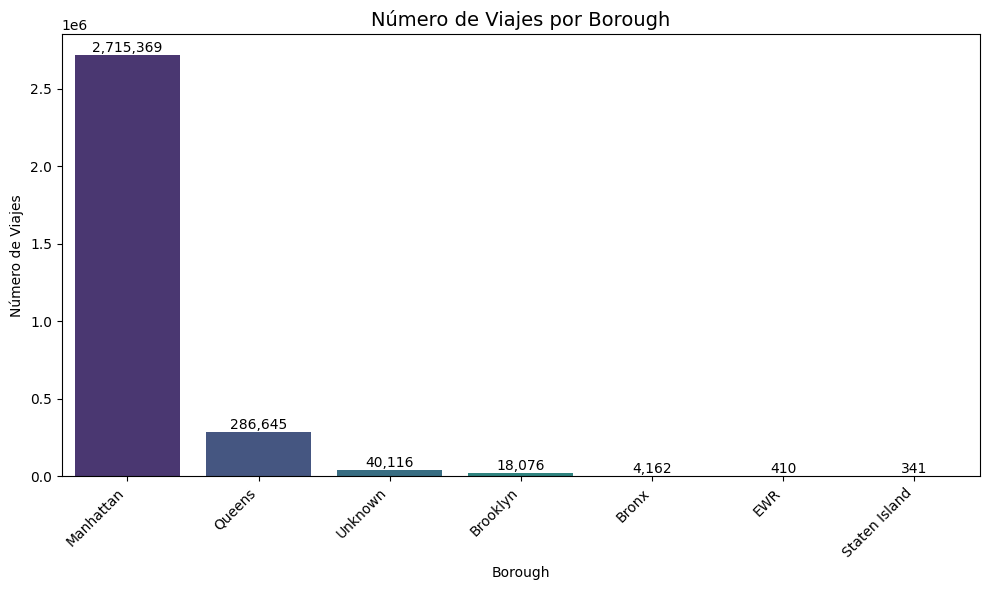

In [15]:
# === Visualización: Número de viajes por Borough ===
import matplotlib.pyplot as plt
import seaborn as sns


borough_trip_counts = borough_analysis[['num_trips']].reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=borough_trip_counts, x='borough', y='num_trips', palette='viridis')


for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')

plt.title('Número de Viajes por Borough', fontsize=14)
plt.xlabel('Borough')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

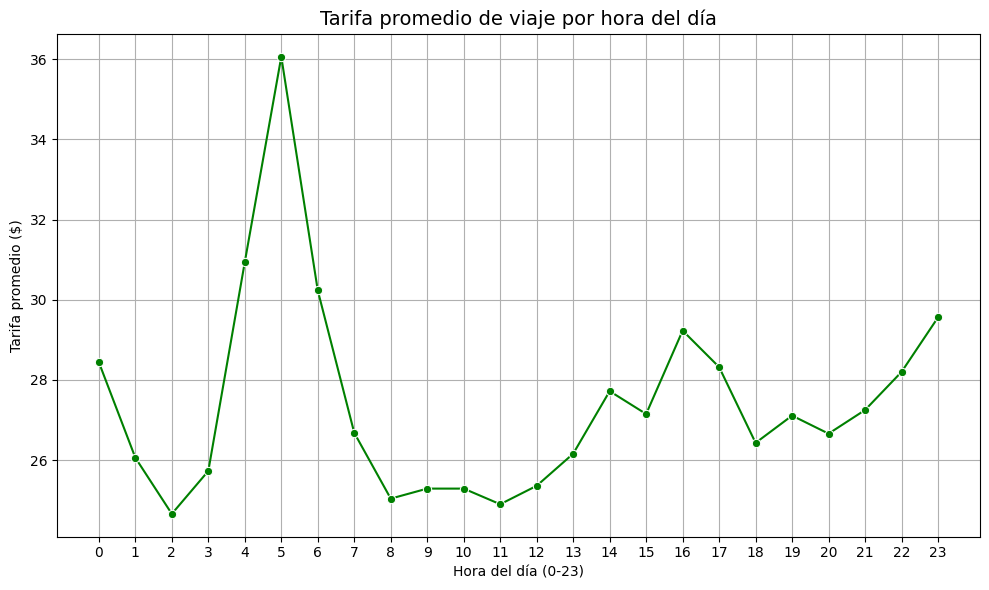

In [16]:
# === Visualización: Tarifa promedio por hora del día ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_analysis, x=hourly_analysis.index, y='avg_amount', marker='o', color='green')

plt.title('Tarifa promedio de viaje por hora del día', fontsize=14)
plt.xlabel('Hora del día (0-23)')
plt.ylabel('Tarifa promedio ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

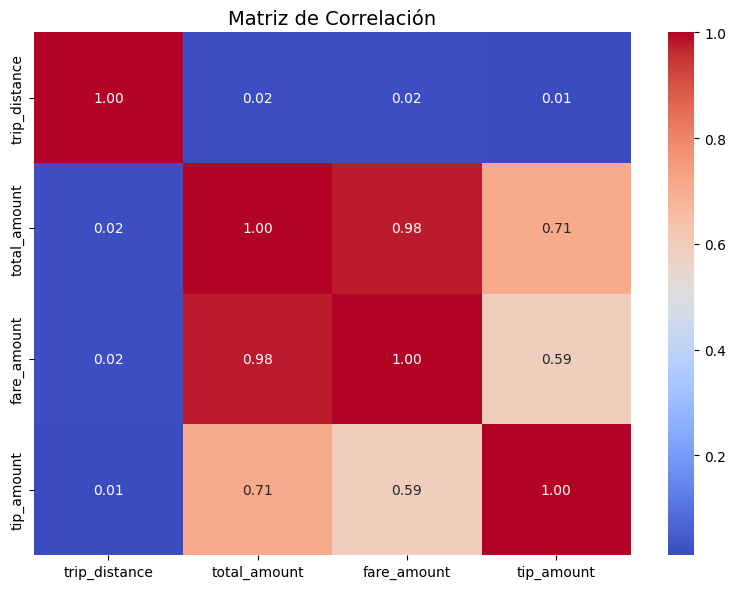

In [17]:
# === Visualización: Matriz de Correlación ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriz de Correlación', fontsize=14)
plt.tight_layout()
plt.show()

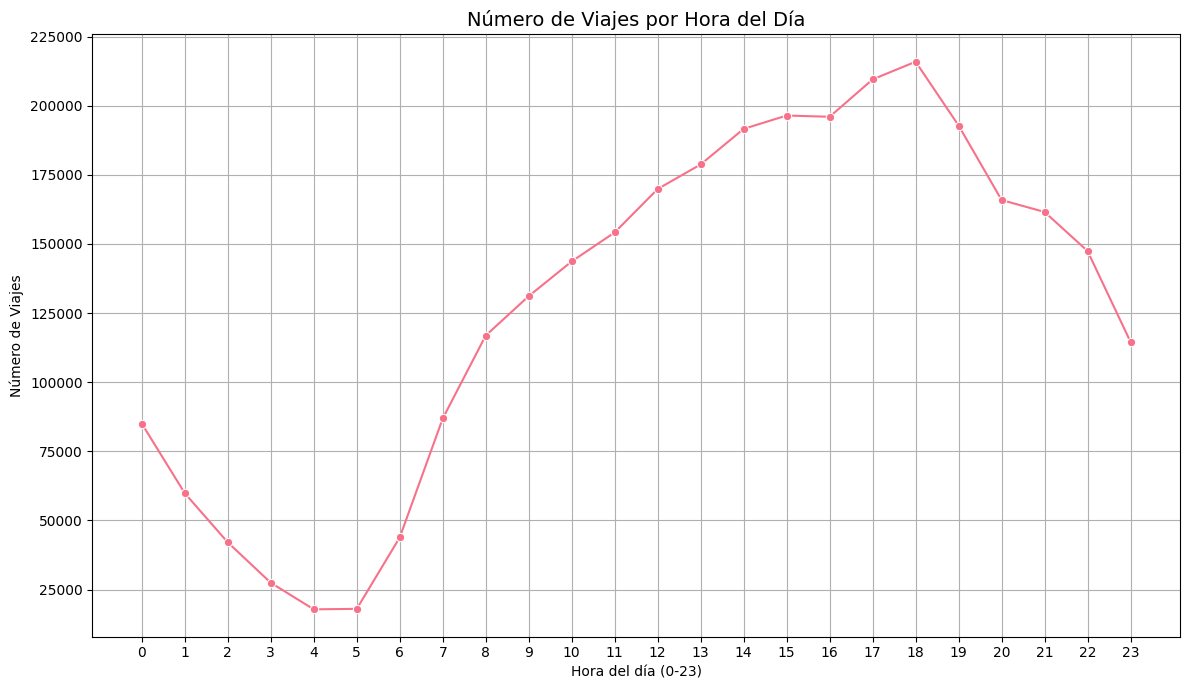

,pickup_hour,num_trips
0,0,84969
1,1,59799
2,2,42040
3,3,27438
4,4,17835


In [18]:
# === Visualización: Número de viajes por hora del día ===
import matplotlib.pyplot as plt
import seaborn as sns


if 'pickup_hour' not in trips_complete.columns:
    trips_complete['pickup_hour'] = trips_complete['tpep_pickup_datetime'].dt.hour


hourly_trip_counts = trips_complete.groupby('pickup_hour').size().reset_index(name='num_trips')


plt.figure(figsize=(12, 7))
sns.lineplot(data=hourly_trip_counts, x='pickup_hour', y='num_trips', marker='o')

plt.title('Número de Viajes por Hora del Día', fontsize=14)
plt.xlabel('Hora del día (0-23)')
plt.ylabel('Número de Viajes')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

hourly_trip_counts.head()